In [1]:
from gcsa.event import Event
from gcsa.google_calendar import GoogleCalendar
from gcsa.recurrence import Recurrence, DAILY, SU, SA

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

from datetime import datetime, timedelta, date, time
import dateutil
from dateutil.parser import parse
import calendar
import numpy as np
from circle_cal.model import CalendarElement
import circle_cal as cc
import circle_cal.model as model
import circle_cal.plot as ccplot
import pathlib
from rich import print
import pytz
from pytz import timezone

In [2]:
ETZ = timezone("America/New_York")
def localize_any(obj, tz):
    try:
        return tz.localize(obj)
    except ValueError:
        if obj.tzinfo:
            return obj
    except AttributeError:
        return datetime.combine(obj, time(0,0), tzinfo=tz)
    return obj

In [3]:
cred = pathlib.Path('/Users/kdavis10/.config/.credentials')
cred_json = "pygooglecal.apps.googleusercontent.com.json"

try:
    gcal = GoogleCalendar(credentials_path=cred / cred_json)
except Exception as e:
    (cred / "token.pickle").unlink()
print(list(enumerate(gcal.get_calendar_list())))

[
    (0, <CalendarListEntry None - (Weather)>),
    (1, <CalendarListEntry None - (Payments)>),
    (2, <CalendarListEntry None - (Axis Ludi Calendar)>),
    (3, <CalendarListEntry None - (NYT Astronomy and Space Calendar)>),
    (4, <CalendarListEntry None - (LIPS 2015)>),
    (5, <CalendarListEntry None - (ND-DVT Provisional Shows)>),
    (6, <CalendarListEntry None - (keithwdavis@gmail.com)>),
    (7, <CalendarListEntry None - (Work)>),
    (8, <CalendarListEntry None - (Cognoscenti)>),
    (9, <CalendarListEntry None - (Academic Calendar)>),
    (10, <CalendarListEntry None - (Descriptive Astronomy)>),
    (11, <CalendarListEntry None - (DVT Student Work Schedule)>),
    (12, <CalendarListEntry None - (PTE Meal Plan (recipes))>),
    (13, <CalendarListEntry None - (LIPS 2013 Calendar (August 2 Revision))>),
    (14, <CalendarListEntry None - (indivisibleIN02 Action Calendar)>),
    (15, <CalendarListEntry None - (Clemson Planetarium)>),
    (16, <CalendarListEntry None - (Birthdays)>),
    (17, <CalendarListEntry None - (Remember The Milk)>),
    (18, <CalendarListEntry None - (Phases of the Moon)>),
    (19, <CalendarListEntry None - ( Wolverhampton)>),
    (20, <CalendarListEntry None - (Chicago Fire)>),
    (21, <CalendarListEntry None - (GenCon 2019)>),
    (22, <CalendarListEntry None - (Holidays in United States)>),
    (23, <CalendarListEntry None - (kdavis10@nd.edu)>),
    (24, <CalendarListEntry None - (DVT Student Work UNAVAILABLE)>),
    (25, <CalendarListEntry None - (Great Lakes Planetarium Association)>),
    (26, <CalendarListEntry None - (Tasks Personal)>),
    (27, <CalendarListEntry None - (Legend Secondary)>),
    (28, <CalendarListEntry None - (Legend Main)>),
    (29, <CalendarListEntry None - (TD Trips)>),
    (30, <CalendarListEntry None - (Food)>),
    (31, <CalendarListEntry None - (Tasks: Work)>),
    (32, <CalendarListEntry None - (TD Work Projects)>)
]

In [4]:
year = y24 = CalendarElement(year=2024)

traces = []

clist = list(gcal.get_calendar_list())



In [5]:
dfs = []
for cid in [6, 9, 23, 31,26]:
    events = gcal.get_events(y24.start.datetime(),
                             y24.stop.datetime(),
                             single_events=True,
                             calendar_id=clist[cid].calendar_id,
                            )

    df = pd.DataFrame(data=[model.EventWrap(ev) for ev in events if ev.other["eventType"] != "workingLocation"],
                      columns=["Event_obj"]
                     )
    
    df["cid"] = cid
    df["color"] = clist[cid].background_color
    df["calendar_id"] = clist[cid].calendar_id
    dfs.append(df)
    
df = pd.concat(dfs, axis="rows", ignore_index=True)
df["duration"] = df["Event_obj"].apply(lambda ev: ev.duration)
df["mid"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.mid, ETZ)), utc=True).dt.tz_convert(ETZ)
df["start"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.start, ETZ)), utc=True).dt.tz_convert(ETZ)
df["end"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.end, ETZ)), utc=True).dt.tz_convert(ETZ)
#df["end"] = df["Event_obj"].apply(lambda ev: ev.end)


df["summary"] = df["Event_obj"].apply(lambda ev: ev.summary)


In [6]:
df24 = df[df["start"] >= pd.Timestamp("2024-01-01", tzinfo=ETZ)]
df24 = df24[df24["start"] <= pd.Timestamp("2025-01-01", tzinfo=ETZ)]

In [7]:
ii = pd.IntervalIndex([pd.Interval(pd.Timedelta(days=0), pd.Timedelta(days=1)),
                       pd.Interval(pd.Timedelta(days=1), pd.Timedelta(days=1)),
                       pd.Interval(pd.Timedelta(days=1), pd.Timedelta(days=7)),
                       pd.Interval(pd.Timedelta(days=7), pd.Timedelta(days=31)),
                       pd.Interval(pd.Timedelta(days=31), pd.Timedelta(days=365))])
intervalsdf = pd.DataFrame(data=["hours", "day", "days", "weeks", "months"], index=ii, columns=["name"])

In [8]:
df["scale"] = pd.cut(df["duration"], intervalsdf.index)

In [9]:
df["scale"]

0      (0 days 00:00:00, 1 days 00:00:00]
1      (0 days 00:00:00, 1 days 00:00:00]
2      (0 days 00:00:00, 1 days 00:00:00]
3      (0 days 00:00:00, 1 days 00:00:00]
4      (0 days 00:00:00, 1 days 00:00:00]
                      ...                
627    (0 days 00:00:00, 1 days 00:00:00]
628    (0 days 00:00:00, 1 days 00:00:00]
629    (0 days 00:00:00, 1 days 00:00:00]
630    (0 days 00:00:00, 1 days 00:00:00]
631    (0 days 00:00:00, 1 days 00:00:00]
Name: scale, Length: 632, dtype: category
Categories (5, interval[timedelta64[ns], right]): [(0 days 00:00:00, 1 days 00:00:00] < (1 days 00:00:00, 1 days 00:00:00] < (1 days 00:00:00, 7 days 00:00:00] < (7 days 00:00:00, 31 days 00:00:00] < (31 days 00:00:00, 365 days 00:00:00]]

In [10]:
df["ring"] = intervalsdf.loc[df["scale"]].reset_index(drop=True)

In [22]:
def ts_to_theta(ts, day_to_theta=365/360):
    return ts / day_to_theta

def ring_to_base(ring, intervalsdf):
    rvalues = [1, 5/6, 4/6, 3/6, 2/6, 1/6]
    d = dict(zip(intervalsdf.name.values, rvalues))
    return d[ring]
    
year=y24

df["midtheta"] = df.mid.apply(lambda x: ts_to_theta(model.to_timestamp(x), y24.duration / timedelta(days=1) / 360))
df["width"] = df.duration.apply(lambda x: x / year.duration * 360)
df["rbase"] = df.ring.apply(lambda x: ring_to_base(x, intervalsdf))
df["r"] = df["rbase"]

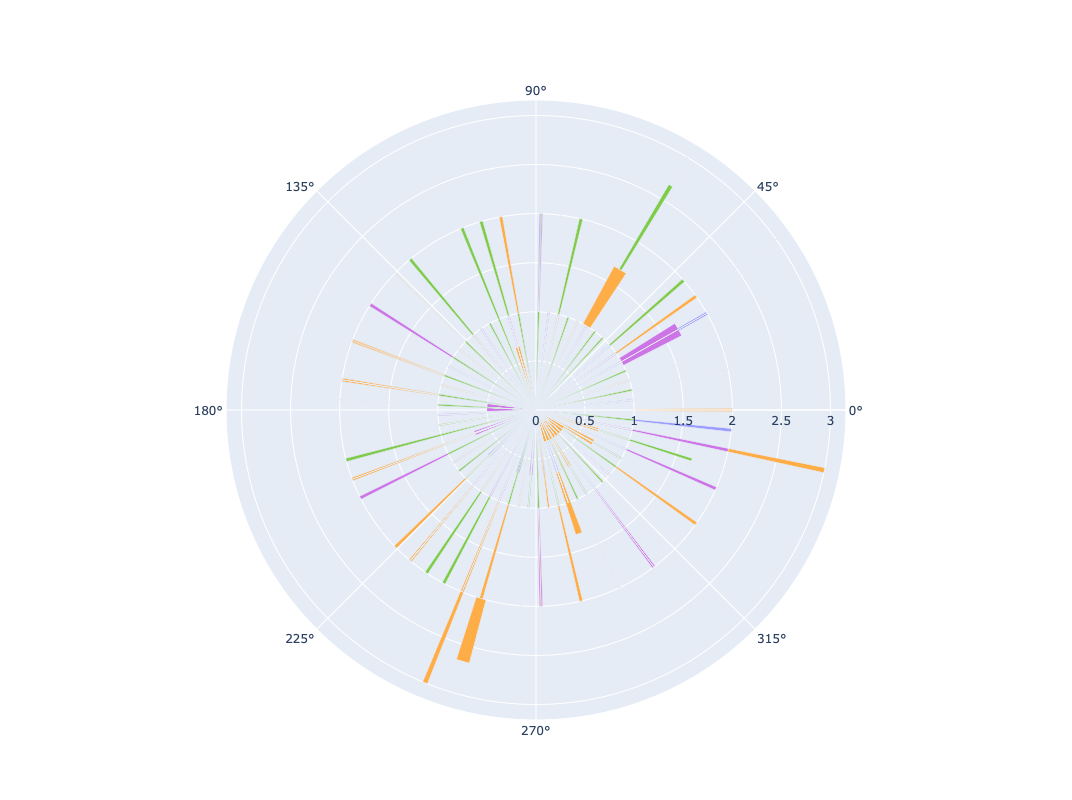

In [26]:
dring = df
try:
    del f
except NameError:
    pass
    
f = go.Figure(go.Barpolar(theta=df.midtheta, r=df.r, width=df.width, #base=df.rbase,
                          text=df.summary, marker_color=df.color))
f.update_layout(height=800)
f.show()

In [33]:
intervalsdf

,name
"(0 days 00:00:00, 1 days 00:00:00]",hours
"(1 days 00:00:00, 1 days 00:00:00]",day
"(1 days 00:00:00, 7 days 00:00:00]",days
"(7 days 00:00:00, 31 days 00:00:00]",weeks
"(31 days 00:00:00, 365 days 00:00:00]",months


In [53]:
np.linspace(1 / len(intervalsdf), 1, len(intervalsdf)+1)

array([0.2 , 0.36, 0.52, 0.68, 0.84, 1.  ])

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [37]:
rvalues

[np.float64(0.0),
 np.float64(0.2),
 np.float64(0.4),
 np.float64(0.6000000000000001),
 np.float64(0.8),
 np.float64(1.0)]

In [109]:
rvalues.item(0)

0.0

In [111]:
    rvalues = np.linspace(0, 1, len(intervalsdf)+1)
    idf = intervalsdf.reset_index()

In [112]:
idf

,index,name
0,"(0 days 00:00:00, 1 days 00:00:00]",hours
1,"(1 days 00:00:00, 1 days 00:00:00]",day
2,"(1 days 00:00:00, 7 days 00:00:00]",days
3,"(7 days 00:00:00, 31 days 00:00:00]",weeks
4,"(31 days 00:00:00, 365 days 00:00:00]",months


In [114]:
rvalues.item(0)

0.0

In [123]:
int(idf[idf["name"]=="day"].index.values[0])

1

In [27]:
intervalsdf[intervalsdf.name == "hours"]

,name
"(0 days 00:00:00, 1 days 00:00:00]",hours


In [47]:
intervalsdf.reset_index().reset_index().set_index("name").rename(columns={"level_0": "idx"}).drop(columns="index").to_dict()

{'idx': {'hours': 0, 'day': 1, 'days': 2, 'weeks': 3, 'months': 4}}

In [50]:
    rvalues = reversed(range(1, len(intervalsdf)))

[4, 3, 2, 1]

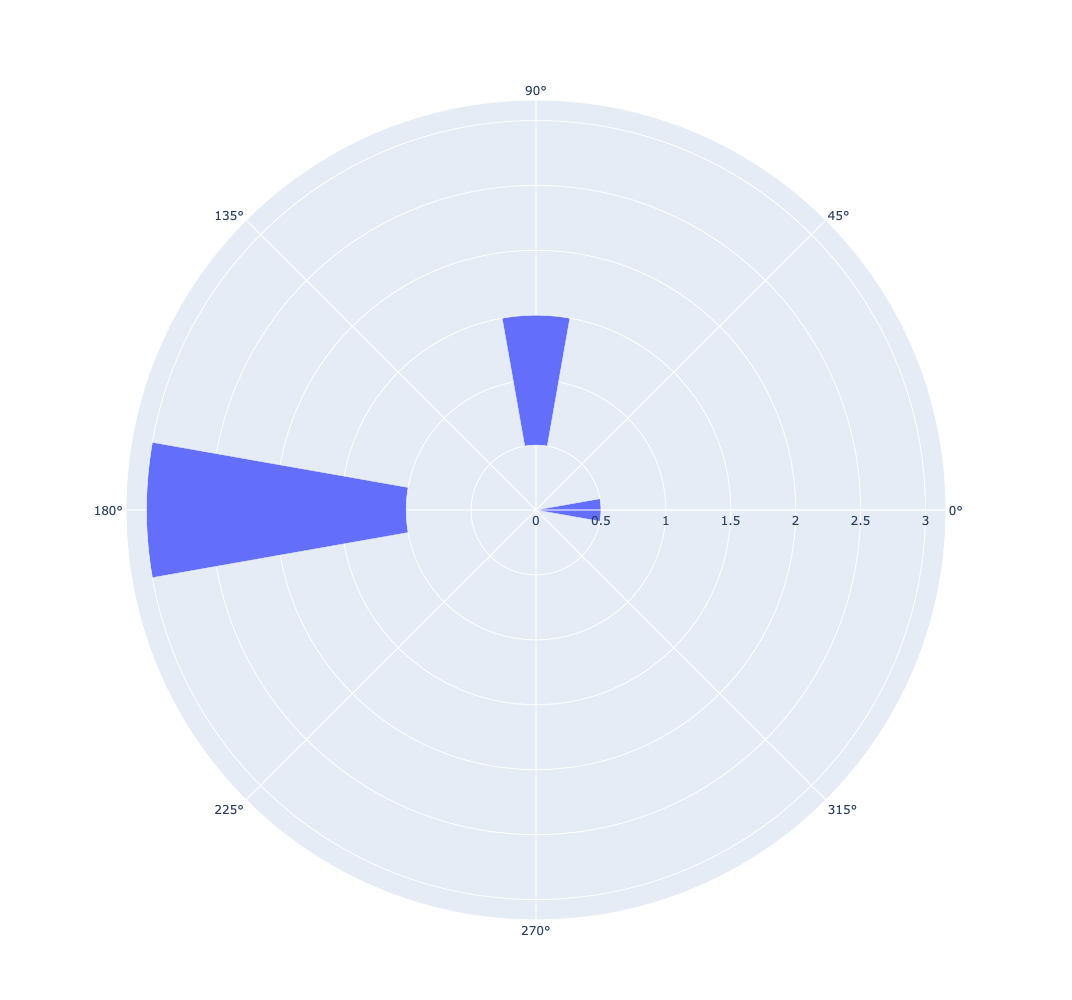

In [32]:
fig = go.Figure(go.Barpolar(r=[0.5, 1, 2], theta=[0, 90, 180], base=[0, 0.5, 1], width=20))
fig.update_layout(height=1000)
fig.show()